In [1]:
from SimPEG import Mesh, Maps
import numpy as np
from matplotlib.colors import LogNorm
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, get_vertical_discretization_time, EM1DSurveyTD
)
from pymatsolver import PardisoSolver
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Seting up a 2D mesh and model

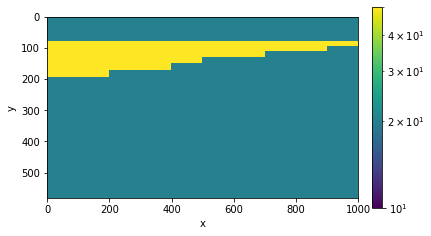

In [2]:
from simpegEM1D import skytem_HM_2015
wave = skytem_HM_2015()
time = np.logspace(-5, -2, 21)
# hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)
hz = 1*np.arange(30)**1.1
time_input_currents = wave.current_times[-7:]
input_currents = wave.currents[-7:]
from scipy.spatial import Delaunay
def PolygonInd(mesh, pts):
    hull = Delaunay(pts)
    inds = hull.find_simplex(mesh.gridCC)>=0
    return inds
n_sounding = 10
dx = 100.
hx = np.ones(n_sounding) * dx
mesh = Mesh.TensorMesh([hx, hz], x0='00')
inds =  mesh.gridCC[:,1]<25
sigma = np.ones(mesh.nC) * 1./20.
sigma[inds] = 1./20.
x0 = np.r_[0., 75.]
x1 = np.r_[dx*n_sounding, 75.]
x2 = np.r_[dx*n_sounding, 90.]
x3 = np.r_[0., 200.]
pts = np.vstack((x0, x1, x2, x3, x0))
poly_inds = PolygonInd(mesh, pts)
sigma[poly_inds] = 1./50.
sigma_em1d = sigma.reshape(mesh.vnC, order='F').flatten()
cb = plt.colorbar(
    mesh.plotImage(1./sigma, grid=False, clim=(10, 50),pcolorOpts={"norm":LogNorm()})[0],
    fraction=0.03, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

In [3]:
from SimPEG import (
    Regularization, Directives, Inversion, InvProblem, Optimization, DataMisfit, Utils
)
from simpegEM1D import get_2d_mesh, LateralConstraint

In [4]:
x = mesh.vectorCCx
y = np.zeros_like(x)
z = np.ones_like(x) * 30.
rx_locations = np.c_[x, y, z]
src_locations = np.c_[x, y, z]
topo = np.c_[x, y, z-30.].astype(float)

mapping = Maps.ExpMap(mesh)

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    topo = topo,
    time = [time for i in range(n_sounding)],
    src_type = np.array(["CircularLoop"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    wave_type = np.array(["stepoff"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    a = np.array([13.]).repeat(n_sounding),
    input_currents=[input_currents for i in range(n_sounding)],
    time_input_currents=[time_input_currents for i in range(n_sounding)],
    base_frequency = np.array([20.]).repeat(n_sounding),
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=False, n_cpu=2,
    Solver=PardisoSolver
)
prob.pair(survey)
m = np.log(sigma_em1d)
dobs = survey.makeSyntheticData(m, std=0.03, force=True)

>> Set parameters
>> Serial version is used
SimPEG.Survey assigned new std of 3.00%


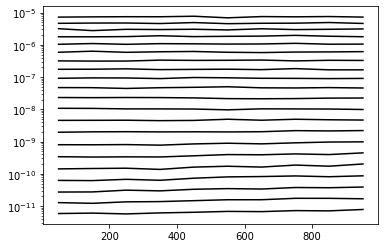

In [5]:
DOBS = dobs.reshape(( prob.n_sounding, time.size))
for i_time in range(time.size):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,i_time], 'k')

In [153]:
mesh_reg = get_2d_mesh(n_sounding, hz)
regmap = Maps.IdentityMap(mesh_reg)
# mapping is required ... for IRLS
reg = LateralConstraint(
    mesh_reg, mapping=regmap,
    alpha_s = 1.,
    alpha_x = 1.,
    alpha_y = 1,    
)
xy = Utils.ndgrid(np.arange(n_sounding), np.r_[0.])
reg.get_grad_horizontal(xy, hz, dim=2)

True

In [154]:
std = 0.03
floor = 0.
np.random.seed(1)
uncert = std*abs(dobs)+floor
survey.dobs = dobs.copy()
m0 = np.ones(mesh.nC) * np.log(1./20.)
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert
# p = 0
# qx, qz = 1., 1.
# reg.norms = np.c_[p, qx, qz, 0.]
# IRLS = Directives.Update_IRLS(
#     maxIRLSiter=5, minGNiter=1, fix_Jmatrix=True,
#     betaSearch=False
# )
opt = Optimization.InexactGaussNewton(maxIter = 30)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta,betaest,target])
# inv = Inversion.BaseInversion(invProb, directiveList=[IRLS,betaest])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.16e+01  3.96e+03  0.00e+00  3.96e+03    3.71e+03      0              
   1  1.58e+01  8.10e+02  1.89e+01  1.11e+03    5.24e+02      0              
   2  7.91e+00  4.54e+02  3.34e+01  7.18e+02    2.59e+02      0   Skip BFGS  
   3  3.95e+00  2.85e+02  4.88e+01  4.78e+02    1.60e+02      0   Skip BFGS  
   4  1.98e+00  1.91e+02  6.60e+01  3.22e+02    9.59e+01      0   Skip BFGS  
   5  9.88e-01  1.41e+02  8.38e+01  2.24e+02    5.73e+01      0   Skip 

In [114]:
sigma_est = Utils.mkvc((np.exp(mopt)).reshape((prob.n_sounding, prob.n_layer)))
# sigma_est_l2 = Utils.mkvc((np.exp(invProb.l2model)).reshape((prob.n_sounding, prob.n_layer)))

In [115]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

Text(0.5, 1.0, 'Laterally-contrained model: L0 L2')

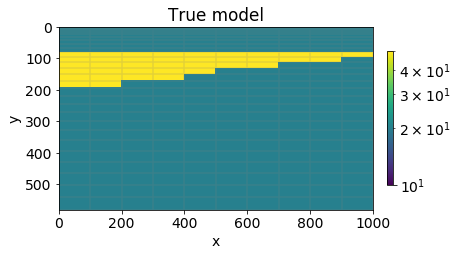

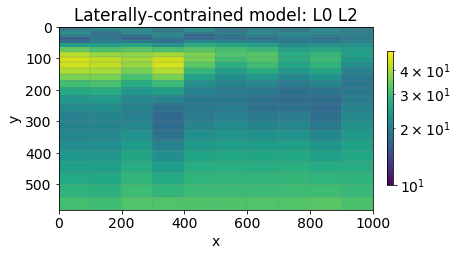

In [116]:
cb = plt.colorbar(
    mesh.plotImage(
        1./sigma, grid=True, clim=(10, 50),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)

plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)

plt.title("True model")


cb = plt.colorbar(
    mesh.plotImage(
        1./sigma_est, grid=True, clim=(10, 50), pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}
    )[0],
    fraction=0.02, pad=0.04
)
plt.ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
plt.gca().set_aspect(1)
plt.title("Laterally-contrained model: L0 L2")

In [155]:
# survey.n_time

In [156]:
n_time = time.size
PRED = invProb.dpred.reshape((prob.n_sounding, n_time))

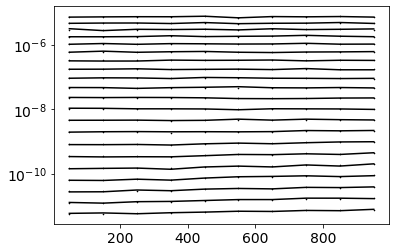

In [157]:
for i_time in range(n_time):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,i_time], 'k')
    plt.semilogy(mesh.vectorCCx, -PRED[:,i_time], 'kx', ms=1)

In [158]:
J_sigma = prob.getJ_sigma(m)
J = J_sigma

In [159]:
from pymatsolver import Pardiso

In [160]:
reg = LateralConstraint(
    mesh_reg, mapping=regmap,
    alpha_s=0.,
    alpha_x = 1.,
    alpha_y = 1.,    
)
xy = Utils.ndgrid(np.arange(n_sounding), np.r_[0.])
reg.get_grad_horizontal(xy, hz, dim=2)

True

In [161]:
betaest.initialize()

In [162]:
betaest.beta0 

24.06444818614206

In [163]:
n_sample = 100
Wd = dmisfit.W
beta_post = betaest.beta0 * 0.01
Hd = J.T.dot((Wd.T*(Wd*J)))
Hm = reg.W.T*reg.W
H = Hd + beta_post * Hm
# L = np.linalg.cholesky(H)
Hinv = Pardiso(H, is_symmetric=True, is_positive_definite=True)
Hinv.factor()
rhs = np.random.randn(H.shape[0], n_sample)
x = Hinv.solver.run_pardiso(333, rhs=rhs)

In [164]:
x_tmp = np.random.rand(mopt.size)
Wd = dmisfit.W
beta_0 = np.linalg.norm(Wd*(J*x_tmp))**2 / np.linalg.norm((reg.W*x_tmp))**2

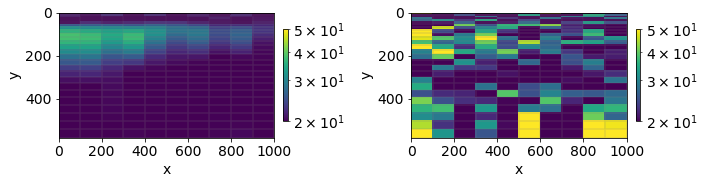

In [165]:
fig = plt.figure(figsize=(10, 5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ii = 2
sigma_est = Utils.mkvc((np.exp(mopt)).reshape((prob.n_sounding, prob.n_layer)))
cb = plt.colorbar(
    mesh.plotImage(
        1./sigma_est, grid=True, clim=(20, 50),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}, ax=ax1
    )[0],
    fraction=0.02, pad=0.04, ax=ax1
)
sigma_est = Utils.mkvc((np.exp(mopt+x[:,ii])).reshape((prob.n_sounding, prob.n_layer)))
cb = plt.colorbar(
    mesh.plotImage(
        1./sigma_est, grid=True, clim=(20, 50),pcolorOpts={"norm":LogNorm()},
        gridOpts={'alpha':0.2, 'color':'grey'}, ax=ax2
    )[0],
    fraction=0.02, pad=0.04, ax=ax2
)
for ax in [ax1, ax2]:
    ax.set_ylim(mesh.vectorNy.max(), mesh.vectorNy.min())
    ax.set_aspect(1)
plt.tight_layout()

In [166]:
from simpegEM1D import set_mesh_1d, plotLayer
mesh_1d = set_mesh_1d(hz)

1000


(2, 200)

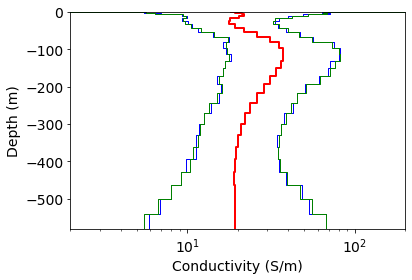

In [167]:
ii=1
n_samples = [3, 5, 20, 50, 80, 100, 200, 300, 400, 500, 600, 700, 1000, 10000]
lows = []
highs = []
perc_low = 2.1
for n_sample in n_samples:
    rhs = np.random.randn(H.shape[0], n_sample)
    x = Hinv.solver.run_pardiso(333, rhs=rhs)
    ind_start = ii*hz.size
    ind_end = ii*hz.size + hz.size
    tmp = mopt[ind_start:ind_end, np.newaxis] + x[ind_start:ind_end,:]
    low = np.percentile(tmp, perc_low, axis=1)
    high = np.percentile(tmp, 100-perc_low, axis=1)
    lows.append(low)
    highs.append(high)
# for jj in range(len(n_samples)):
jj = 12
print (n_samples[jj])
plotLayer(1./np.exp(lows[jj]), mesh_1d,  **{'color':'b', 'lw':1})
plotLayer(1./np.exp(highs[jj]), mesh_1d, **{'color':'b', 'lw':1})

plotLayer(1./np.exp(lows[len(n_samples)-1]), mesh_1d,  **{'color':'g', 'lw':1})
plotLayer(1./np.exp(highs[len(n_samples)-1]), mesh_1d, **{'color':'g', 'lw':1})
plotLayer(
    1./np.exp(mopt[ind_start:ind_end, np.newaxis]), 
    mesh_1d, showlayers=False,**{'color':'r', 'lw':2}
)
plt.xlim(2, 200)
# 500 samples    

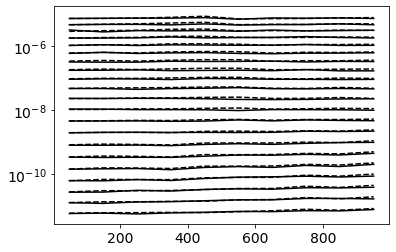

In [168]:
ii = 12
dpred = survey.dpred(mopt+x[:,ii])
n_time = time.size
PRED = dpred.reshape((prob.n_sounding, n_time))

for i_time in range(n_time):
    plt.semilogy(mesh.vectorCCx, -DOBS[:,i_time], 'k')
    plt.semilogy(mesh.vectorCCx, -PRED[:,i_time], 'k--', ms=5)